In [1]:
import json
import gzip
import pandas as pd
import numpy as np 
import tensorflow as tf 
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from keras.callbacks import EarlyStopping

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(r"C:\Users\rishi\ml_projects\reviews\Video_Games.json.gz")
df=df.drop(["reviewTime","reviewerID","vote","style","image","unixReviewTime","reviewerName"],axis=1)
df=shuffle(df)
df=df.reset_index(drop=True)
df=df[:30000]
df['overall']=df['overall'].apply(lambda x: float(x))
df['reviewText']=df['reviewText'].apply(lambda x: str(x))
df['summary']=df['summary'].apply(lambda x: str(x))
train,valid,test=df[:1000], df[2000:2100], df[2200:2300]


In [3]:
train.head(10)

,overall,verified,asin,reviewText,summary
0,5.0,False,B0000657SP,This is the best Resident Evil game of them al...,Best Resident Evil
1,4.0,True,B000OAO188,I like it and use it a lot.,Four Stars
2,2.0,True,B002B9XB0E,The top arrow (up) didn't work. They did promp...,The top arrow (up) didn't work. They did promp...
3,1.0,True,B00004U5VN,Horrible! I ordered this game and even express...,HORRIBLE
4,5.0,False,B000FRS9II,"With the Playstation 3 on the horizon, Microso...",Easily the Game of the Year
5,5.0,True,B004YNEDW0,this game is awesome bought it a few weeks ago...,Great buy for civ lovers
6,5.0,False,B00139PR5U,I received this game with the Wii console that...,Very Entertaining
7,1.0,True,B00CXI0BPG,Does not allow Macros or keystroks to be assig...,No macro function
8,5.0,True,B0028UB054,This is just what I needed.,Love this
9,5.0,False,B00005V6BE,This game is responsible for single handedly s...,"break the law, and feel damn good about it!"


In [4]:
textsamples=train["reviewText"]
validsamples=valid["reviewText"]
testsamples=test["reviewText"]

textsa=[]
validsa=[]
testsa=[]
textsamples.apply(lambda x: textsa.append(x))
textsamples=tf.constant(textsa)
validsamples.apply(lambda x: validsa.append(x))
validsamples=tf.constant(validsa)
testsamples.apply(lambda x: testsa.append(x))
testsamples=tf.constant(testsa)


In [5]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

In [6]:
embedding_model=keras.Model(text_input,[pooled_output])
embedded_text=embedding_model(textsamples)
valid_text=embedding_model(validsamples)
test_text=embedding_model(testsamples)

In [7]:
train_set=tf.data.Dataset.from_tensor_slices((embedded_text,train['overall'][:20000]))
valid_set=tf.data.Dataset.from_tensor_slices((valid_text,valid['overall']))
test_set=tf.data.Dataset.from_tensor_slices((test_text,test['overall']))
batchsize=32
train_set=train_set.map(lambda x, y:(x,int(y)-1))
valid_set=valid_set.map(lambda x, y:(x,int(y)-1))
test_set=test_set.map(lambda x, y:(x,int(y)-1))
train_set=train_set.batch(batchsize)
valid_set=valid_set.batch(batchsize)
test_set=test_set.batch(batchsize)
for ele in train_set:
    print(ele)
    break

(<tf.Tensor: shape=(32, 512), dtype=float32, numpy=
array([[ 0.9885218 ,  0.87663287, -0.14390217, ...,  0.10469066,
        -0.420909  ,  0.3997377 ],
       [ 0.9992039 ,  0.23618811, -0.1626041 , ...,  0.3696426 ,
        -0.43836442, -0.43242505],
       [ 0.98929375,  0.9595534 , -0.16625674, ...,  0.06634524,
        -0.395248  , -0.7245294 ],
       ...,
       [ 0.85642326,  0.9899979 ,  0.03429705, ...,  0.06656803,
        -0.6027528 , -0.83149064],
       [ 0.99242234,  0.68576133, -0.16239531, ..., -0.01783016,
        -0.5875921 , -0.02931814],
       [ 0.93250835,  0.9964297 , -0.00940338, ...,  0.05845468,
        -0.6218287 , -0.88973874]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 3, 1, 0, 4, 4, 4, 0, 4, 4, 4, 3, 4, 4, 4, 1, 4, 0, 4, 4, 4, 4,
       3, 2, 2, 4, 4, 3, 4, 4, 0, 4])>)


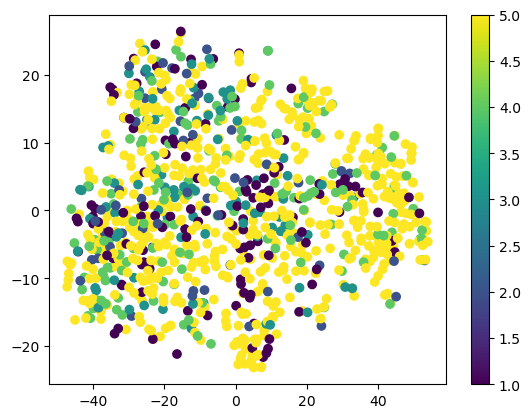

In [8]:
labels=np.array(train['overall'])
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embedded_text)
plt.scatter(embeddings_tsne[:,0],embeddings_tsne[:,1],c=labels)
plt.colorbar()
plt.show()

In [9]:
inputs=keras.Input(shape=(512,))
features=layers.Dense(64,activation='relu')(inputs)
outputs=layers.Dense(5,activation='softmax')(features)
earlystopping=EarlyStopping(monitor="val_accuracy",mode="max",patience=10,restore_best_weights=True)
model=keras.Model(inputs,outputs)
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
watch=model.fit(train_set,epochs=35,validation_data=valid_set,callbacks=[earlystopping])

Epoch 1/35


32/32 [==============================] - 1s 8ms/step - loss: 1.2345 - accuracy: 0.5660 - val_loss: 1.1840 - val_accuracy: 0.5900
Epoch 2/35
32/32 [==============================] - 0s 4ms/step - loss: 1.0847 - accuracy: 0.5980 - val_loss: 1.1407 - val_accuracy: 0.5900
Epoch 3/35
32/32 [==============================] - 0s 4ms/step - loss: 1.0360 - accuracy: 0.6220 - val_loss: 1.1181 - val_accuracy: 0.5900
Epoch 4/35
32/32 [==============================] - 0s 3ms/step - loss: 0.9970 - accuracy: 0.6360 - val_loss: 1.1094 - val_accuracy: 0.5900
Epoch 5/35
32/32 [==============================] - 0s 4ms/step - loss: 0.9695 - accuracy: 0.6420 - val_loss: 1.1240 - val_accuracy: 0.5900
Epoch 6/35
32/32 [==============================] - 0s 4ms/step - loss: 0.9444 - accuracy: 0.6500 - val_loss: 1.0967 - val_accuracy: 0.6300
Epoch 7/35
32/32 [==============================] - 0s 4ms/step - loss: 0.9155 - accuracy: 0.6570 - val_loss: 1.1038 - val_accuracy: 0.6200
Epoch 8/35
32/32 [=============

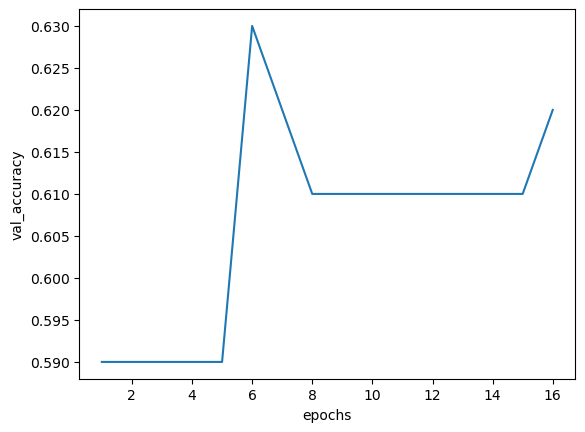

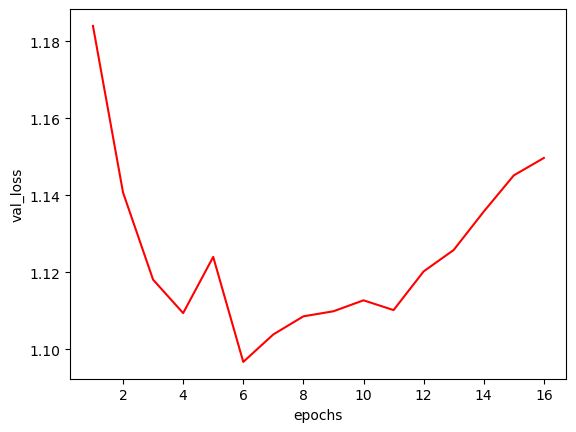

In [11]:
historydict=watch.history
val_accuracy=historydict['val_accuracy']
epochs=range(1,len(val_accuracy)+1)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.plot(epochs,val_accuracy)
fig2=plt.figure()
plt.plot(epochs,historydict['val_loss'],'r')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.show()

In [12]:
y_predictions=model.predict(test_set)
finalpred=[]
for row in y_predictions:
    finalpred.append(np.argmax(row)+1)
finalpred=np.array(finalpred)
actual=test['overall'].apply(lambda x: int(x))
actual=np.array(actual)
print(finalpred)
print(actual)

4/4 [==============================] - 0s 3ms/step
[5 5 5 5 4 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 1 5 5 5
 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 4 1 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 1 5 5 5 5 5 3 5 5 3 5 5 5 5 5 5 5 5 1 5]
[5 5 4 5 4 4 5 5 5 5 1 5 5 3 2 5 3 1 5 5 5 5 5 4 5 5 5 3 5 5 4 5 4 3 5 5 5
 4 5 5 3 5 4 1 3 5 5 4 5 5 1 5 5 1 5 5 3 5 5 3 5 5 2 3 4 5 4 4 5 2 5 5 5 4
 5 3 5 5 5 3 5 4 5 5 3 5 3 1 5 3 5 3 5 5 4 5 3 5 3 5]


In [13]:
def calc_accuracy(predictions,actual):
    correct=0
    for i in range(0, len(predictions)):
        if(predictions[i]==actual[i]):
            correct+=1
    return correct/len(predictions)
accuracy=calc_accuracy(finalpred,actual)
print(f"accuracy:{accuracy}")

accuracy:0.61
